In [1]:
%matplotlib inline

### Dynamic prgramming  ###
The optimality equation for the stochastic problem is given by:
\begin{equation}
V(h,j,i) = \min_x \left(  p_{j,k} C(x,i,k) + \sum_{k = 1}^{k=K} p_{j,k} V(i+1,k)   \right)
\end{equation}
When implimented for a WDS for with one pump this is implimented as:
\begin{equation}
V(h,j,i) = min \left(C(i,k) + \sum_{k = 1}^{k=K} p_{j,k} V(h_i - D_i + P,k,i+1), 
\sum_{k = 1}^{k=K} p_{j,k} V_{i+1}(h_i - D_i ,k,i+1 )  \right)
\end{equation}
where $p_{j}$ is the slice of P with k elements. P is a $ J \times J $ matrix  describing the probability of changing state from j to k if at state j.

### Schedule tracking ###
The schedule and expected energy cost are tracked using a predecessor array. 

### Energy cost C ###
The energy cost of operation are dependant on the energy source.

#### Spot price ####
 For a sport price purchase of electricity there is a price forecast and a realised price
 
#### Wind power ####
For wind power there is a wind power forecast and a realised wind speed, resulting in a certain power. The cost of operating are the cost of purchasing extra electricty to feed the pumps energy demand for fixed speed pumps.

Wind power = f(Wind speed)

C = max((Pump_power - Wind power)*Tariff,0)



#### Some Import statements

In [2]:
from __future__ import division
import numpy as np
from scipy import optimize
import csv
import matplotlib.pyplot as plt
import random
from basic_definitions import *
from math import floor
import time      
from IPython.core.debugger import Tracer
import matlab.engine
from tqdm import tqdm

### Some initial loading of  data on pumps, networks and wind 

#### Wind

#### Network

In [3]:
#flow =[]
#step = 0.1
tank = Tank(Elev=20,Hmin=0,Hmax=2,Dia=10,levels = 100)
Pipe = pipe(L = 1000,D = 0.5,Method = "DW")
pump = Hyd_pump("ETAline-100-100-210-FSD.crv")

#### Wind

In [4]:
Speed =get_wind_data('WindData.csv')
spd = []
for i in Speed:
    try:
        spd.append(float(i)*0.514444)
        
    except ValueError:
        print i + " is not a float"

pwr = []
for i in range(0,27):
    pwr.append(Turb_power(i))
    
    
P_matrix, J_max = make_P_matrix('P_matrix_all.csv') #TurkeyMatrix.csv, T_matrix_all.csv, P_matrix_all.csv, ProbabilityMatrix.csv    

SPD is not a float
*** is not a float


#### Data

In [5]:
# from epanet
#Demand = [00.5, 0.4, 0.39, 0.45, 0.56, 0.6, 0.8, 1.4, 1.7, 1.8, 1.6, 1.2, 1, 0.8, 0.75, 0.72, 0.7, 0.75, 0.7, 0.8, 0.82, 0.8, 0.79, 0.95, 1.1, 1.3, 1.2, 1.1, 1.4, 1.6, 1.65, 1.8, 2.2, 1.7, 1.8, 1.3, 1.2, 0.8, 0.7, 0.5, 0.45, 0.4, 0.4, 0.4, 0.38]
# from MATLAB
Demand = [0.0379, 0.0398, 0.0426, 0.0473, 0.0379, 0.0369, 0.0426, 0.0530, 0.0568, 0.0757, 0.1325, 0.1609, 0.1704, 0.1515, 0.1136, 0.0947, 0.0757, 0.0710, 0.0682, 0.0663, 0.0710, 0.0663, 0.0757,  0.0776, 0.0757, 0.0748, 0.0899, 0.1041, 0.1231, 0.1136, 0.1041, 0.1325, 0.1515, 0.1562, 0.1704, 0.2083, 0.1609, 0.1704, 0.1231, 0.1136, 0.0757, 0.0663, 0.0473, 0.0426, 0.0379, 0.0379, 0.0379, 0.0360]
change_in_H = np.array(Demand)*60*60/4/tank.Area/10/0.89993

#print np.array(Demand).mean()/0.89993

#### Testing

#### Settings

In [6]:
#J_max = 13 # number of setps
stepsize = 0.2
init =24
T = 24
d_fact = 0.7




In [7]:
## Water demand
#Demand = np.array([0.2, 0.1, 0.5, 0.6,0.1,0.3,0.1,0.05,0.2])/2

## Energy

#P_matrix = P_matrix[0:J_max,0:J_max]
#q = q[0:J_max,0:J_max]

A = spd[init:init+48]
A = list_length_adjustment(A,T*2)

Tariff = [5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 9.6980, 9.6980, 9.6980, 9.6980, 5.7180, 5.7180, 5.7180, 5.7180]
Tariff = list_length_adjustment(Tariff,T)
Tariff.extend(Tariff)
    


#D = provide_speed_range(A,stepsize=stepsize,number_of_steps=J_max)
D = provide_speed_range(A,number_of_steps=J_max,error='bad')

Pwr = np.zeros_like(D)
Cost = np.zeros_like(D)


print np.shape(D)

for i in range(0,np.shape(D)[0]):
    for j in range(0,np.shape(D)[1]):
        Pwr[i,j] = Turb_power(D[i,j])
    

#Tarriff = np.random.rand(1,24)
#print(np.shape(D)[0])
for i in range(0,np.shape(D)[0]):
    
    for j in range(0,np.shape(D)[1]):
        Cost[i,j] = max( (2500-Pwr[i,j])*Tariff[i],0)
        
        
Cost_for_DP = Cost
Cost_for_det = Cost[:,int(np.floor(J_max/2.0))].tolist()

print Cost_for_det

(20L, 48L)
[4941.778433142373, 4423.374845342309, 3906.447971292832, 3394.415021370381, 2890.853496185174, 4798.514716875857, 5832.484994597942, 4447.938414598822, 3012.156563463539, 1234.9687516151753, 105.47998541422305, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


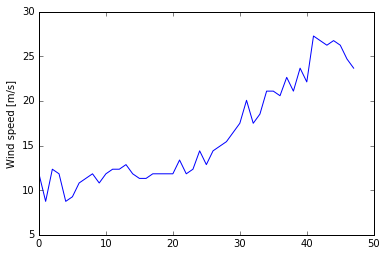

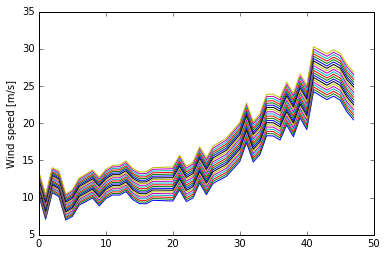

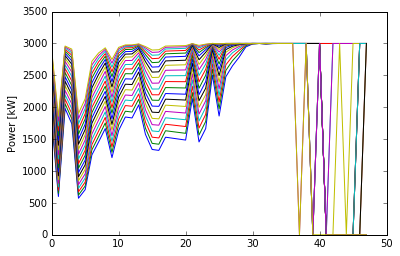

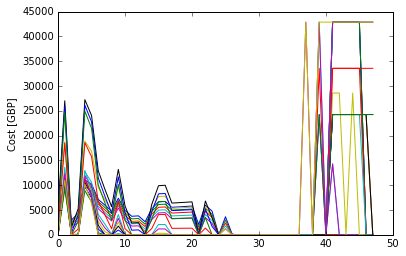

Tariff


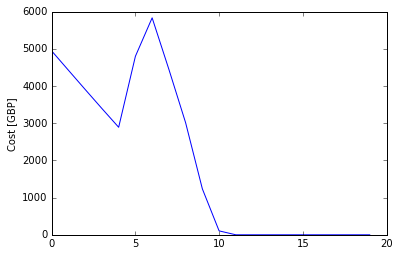

In [8]:
plt.plot(A)
plt.ylabel('Wind speed [m/s]')
plt.show()
#print(A)
plt.plot(D.transpose())
plt.ylabel('Wind speed [m/s]')
plt.show()
plt.plot(Pwr.transpose())
plt.ylabel('Power [kW]')
plt.show()
plt.plot(Cost.transpose())
plt.ylabel('Cost [GBP]')
plt.show()
print "Tariff" 
plt.plot(Cost_for_det)
plt.ylabel('Cost [GBP]')
plt.show()


In [9]:

#Demand_DP = np.array(Demand)*14/tank.Area
pump_perf = gen_flow_rate(tank.levels,tank,Pipe,pump,100)
#print(np.array(pump_perf.values()).mean())
#print(change_in_H.mean())
#Demand_DP = Demand_DP*100
Demand_DP = np.array(change_in_H)/2
Demand_DP = list_length_adjustment(Demand_DP,T)



#### Setting up and defining the problem

In [10]:
start = time.time()
Calc_Cost, Schedule, H_init, h_final, final_val,  H_rec = call_val(H_init=1.0, t_init=0, j_init=int(J_max/2), T=T,Demand=change_in_H*d_fact,\
                                                           Energy=Cost_for_DP[0:24], J_max=J_max,P_matrix = P_matrix,\
                                                           tank=tank, pump_perf=pump_perf)
end = time.time()
print   H_rec
print_schedules_nice( Calc_Cost, Schedule, h_final)    

#print(end - start)

#print final_val

[[1.28, 1.22, 1.18, 1.12, 1.06, 0.92, 0.76, 0.66, 0.58, 0.52, 0.44, 0.36, 0.62, 0.86, 0.74, 0.62, 0.48, 0.3, 0.14, 0.02, 0.28, 0.56, 0.84, 1.12], [1.28, 1.22, 1.18, 1.12, 1.06, 0.92, 0.76, 0.66, 0.58, 0.52, 0.44, 0.36, 0.62, 0.86, 0.74, 0.62, 0.48, 0.3, 0.14, 0.02, 0.28, 0.56, 0.84, 1.12], [1.28, 1.22, 1.5, 1.44, 1.38, 1.24, 1.08, 0.98, 0.9, 0.84, 0.76, 1.02, 1.28, 1.52, 1.4, 1.28, 1.14, 0.96, 0.8, 0.68, 0.6, 0.88, 0.84, 1.12], [1.28, 1.22, 1.5, 1.44, 1.38, 1.24, 1.08, 0.98, 0.9, 0.84, 0.76, 1.02, 1.28, 1.52, 1.4, 1.28, 1.14, 0.96, 0.8, 0.68, 0.6, 0.88, 0.84, 1.12], [1.28, 1.22, 1.5, 1.44, 1.38, 1.24, 1.08, 0.98, 0.9, 0.84, 0.76, 1.02, 1.28, 1.52, 1.4, 1.28, 1.14, 0.96, 0.8, 0.68, 0.6, 0.88, 0.84, 1.12], [1.28, 1.22, 1.5, 1.44, 1.38, 1.24, 1.08, 0.98, 0.9, 0.84, 0.76, 1.02, 1.28, 1.52, 1.4, 1.28, 1.14, 0.96, 0.8, 0.68, 0.6, 0.88, 0.84, 1.12], [1.28, 1.22, 1.5, 1.44, 1.38, 1.24, 1.08, 0.98, 0.9, 0.84, 0.76, 1.02, 1.28, 1.52, 1.4, 1.28, 1.14, 0.96, 0.8, 0.68, 0.6, 0.88, 0.84, 1.12], [1.2

In [11]:
def val_det(s):
    """Deterministic version of Val"""
    # variables that change
    global cost, cache, p, defs, level_defs, pj, costj
    
    # fixed definitions
    Energy, D, H_init, T, J_max, P_matrix, pump_perf = defs
    levels ,Hmax , Hmin, factor = level_defs
    
    #print s
    if s in cache:
        
        return cache[s]
    else:
        h , i = s 

    if h < Hmin or h > Hmax: # h < Hmin or h > Hmax:
        #count_tot += 1  
        v = 1000000000
    elif i == T:  # i = T
        #count_tot += 1  
        if h >= H_init:
            v = h-H_init
        else:
            v = 1000000000 #*(H_init - h)
    else:
        
        # D in m not m/s3
        # pumping(h) returns m not m/s3
        no_pump = val_det((discretise(h-D[i]),i+1))
            
        
        #Energy_cost = Exp([Energy[k,i] for k in range(J_max) ],j)
               
        Energy_cost = Energy[i]
        
        pump = Energy_cost + val_det((discretise(h-D[i]+pumping(h)),i+1))


        v = min(no_pump,pump)
                
        if v == no_pump:
            #costj[i,undiscretise(h),j] = 0
            cost[i,undiscretise(h)] = 0
            #pj[i,undiscretise(h),j] = 0
            p[i,undiscretise(h)] = 0
        elif v == pump:
            #pj[i,undiscretise(h),j] = 1
            p[i,undiscretise(h)] = 1
            #costj[i,undiscretise(h),j] = Energy_cost
            cost[i,undiscretise(h)] = Energy_cost            
        else:
            print "ERROR"

    cache[s] = v
    return v


def print_pump_sched_det(h,t_init = 0,final_cost=[]):
    """Doc string"""
    
    global cost, cache, p, defs
    Energy,D,H_init,T, J_max, P_matrix, pump_perf  = defs
    
    Schedule = np.array(range(1,T+1))
    Calc_Cost = [] 
    H_out =[]
    #H_rec = [[] for i in range(J_max)]
    #for k in range(0,J_max): 
    h = H_init
    calc_cost = 0
    sched = []
    #H_rec[k] = []
    for i in range(t_init,T):       
#         if i == 0:
#             j = j_init
#         else:
#             j = k
        #print i, costj[0,undiscretise(h),j_init]

        if p[i,undiscretise(h)] == 1: 
            sched.append(1)
            calc_cost += cost[i,undiscretise(h)]
            h = discretise(h+pumping(h)-D[i])
        elif p[i,undiscretise(h)] == 0:
            sched.append(0)
            h = discretise(h-D[i])
        else:
            #Tracer()()
            sched.append(np.nan)
            h = discretise(h-D[i])

        #H_out[k].append(h)
            #print pj[i,:,:], i ,undiscretise(h), k 
            #raise NameError('Pj not defined correctly')

        H_out.append(h)
    Calc_Cost.append(calc_cost)
    Schedule = np.vstack((Schedule,sched))
            
    
    return Calc_Cost, Schedule, H_out, H_rec

def call_val_det(H_init,Demand=None, Energy=None ,t_init=0,j_init=0, T=7, J_max=1, P_matrix=None, tank=None,pump_perf=None):
    """Calls the val solver"""
    
    global p, cost, cache, defs,level_defs, pj, costj
    # define stuff:
#     Price_template  = np.array([[2.0, 10.0,  9.0, 3.0, 7.0, 4.0, 3.0,2.0, 10.0,  9.0, 3.0, 7.0, 4.0, 3.0],
#                                 [2.1, 10.1,  9.1, 3.1, 7.1, 4.1, 3.1,2.0, 10.0,  9.0, 3.0, 7.0, 4.0, 3.0],
#                                 [2.2, 10.2,  9.2, 3.2, 7.2, 4.2, 6.2,2.0, 10.0,  9.0, 3.0, 7.0, 4.0, 3.0]])
  
#     Energy = Price_template # no not fiddle
#    D = [0.1, 0.0, 0.2, 0.1, 0.0, 0.4, 0.1,0.1, 0.0, 0.2, 0.1, 0.0, 0.4, 0.1]

    
    if Energy is None:
        Energy = np.random.rand(J_max,T) # replaced with function from wind data
    else:
        Energy = np.array(Energy)
       
        
    if Demand is None:
        Demand = np.random.rand(T)/10
    else:
        Demand = np.array(Demand)
        Demand = list_length_adjustment(Demand,T)
        
    
    if pump_perf is None:
        pump_perf = {0.0: 0.0032918188291391898, 0.5: 0.0032918188291391898, 2.0: 0.0032918188291391898, 1.8: 0.0032918188291391898,
                     1.2: 0.0032918188291391898, 0.2: 0.0032918188291391898, 0.4: 0.0032918188291391898, 1.0: 0.0032918188291391898,
                     0.8: 0.0032918188291391898, 0.6: 0.0032918188291391898, 1.6: 0.0032918188291391898, 0.3: 0.0032918188291391898,
                     0.1: 0.0032918188291391898, 0.9: 0.0032918188291391898, 1.7: 0.0032918188291391898, 1.4: 0.0032918188291391898,
                     1.3: 0.0032918188291391898, 0.7: 0.0032918188291391898, 1.9: 0.0032918188291391898, 1.1: 0.0032918188291391898, 1.5: 0.0032918188291391898}


    
    
    defs = [Energy, Demand, H_init,T, J_max, P_matrix, pump_perf]
    
    if tank is None:
        tank = Tank(20,0,2,Dia=10)
        #Tank.levels =20
        #Tank.Hmax = 2
        #Tank.Hmin = 0
        #Tank.Area = 78.54
        #factor = float(levels / (Hmax-Hmin))
        #level_defs = [levels ,Hmax , Hmin, factor]
        
    #else:
    factor = float(tank.levels / (tank.Hmax-tank.Hmin))
    level_defs = [tank.levels ,tank.Hmax , tank.Hmin, factor]
    
    
    maxHlevels = int(np.ceil(factor*(tank.Hmax+pumping(tank.Hmin))))+1
    p =     np.zeros((T, maxHlevels )) 
    cost =  np.zeros((T, maxHlevels ))   
    #pj =    np.zeros((T, maxHlevels, J_max ))  
    #costj = np.zeros((T, maxHlevels, J_max )) 
    p[:]  =  np.NAN
    cost[:] =np.NAN
    #pj[:]  = np.NAN
    #costj[:]=np.NAN
    
    cache = {}
    
    final_val = val_det( (H_init,t_init) )
    
    if final_val > 10000:
        print "no minimum found"
    
    calc_cost, sched, h_final,  H_rec = print_pump_sched_det(H_init,t_init,final_val)
   
    #print final_val, calc_cost, sched, h_final
    return calc_cost, sched, H_init, h_final , final_val,  H_rec



Calc_Cost_det, Schedule_det, H_init_det, h_final_det, final_val_det,  H_rec_det = \
call_val_det(H_init=1.0, t_init=0, j_init=0, T=24,Demand=change_in_H*d_fact,\
                                                           Energy=Cost_for_DP[5,0:24], J_max=1,\
                                                           tank=tank, pump_perf=pump_perf)

no minimum found


In [12]:
print  Schedule_det

[[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
 [ 1  0  1  0  0  0  0  0  0  0  0  1  1  1  0  0  0  0  0  0  0  1  0  1]]


## Determinsitic Problem

In [13]:
eng = matlab.engine.start_matlab()

In [14]:
det_result = eng.deterministic_WDS_OP(T,'Lecture_example_DP',Cost_for_det,d_fact)
#det_result = eng.deterministic_WDS_OP(T,'Lecture_example_DP',Tariff,d_fact)

In [15]:
#print np.mean(det_result['f'])
#print np.sum(det_result['f'])
print('Fval: ' +str(det_result['fval']))
det_schedule = np.array(det_result['shed'])
print('Schedule: ' +str(det_schedule.flatten().astype(int)))
print('Sum of schedule: '+str(det_schedule.sum()))

Fval: 356151.290733
Schedule: [0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1]
Sum of schedule: 12.0


In [16]:
print Schedule_det[1,2]

1


In [17]:
eng.exit()

In [ ]:
def compute_stoch_cost(T,Cost,schedule,schedule_DP,Pmatrix,Power,j_init,J_max,change_in_H,d_fact,H_rec):
    """
    Computes the operating cost civen a true cost matrix,
    a schedule to follow, the pump conditions and the probability
    matrix.
    
    Computes the stochastic operating cost given
    a certain schedule and the way the wind behaves.
    """
    
    j = j_init
    J_seq = [j]
    Tot_cost_det = 0.0
    
    fval_det = 0.0
    for i in range(T):
        # detminsitc stuff
        #MATLAB
        #Tot_cost_det += schedule[i][0]*Cost[j,i]
        #fval_det +=schedule[i][0]*Cost[ j_init,i]
        
        #DP
        Tot_cost_det += schedule[1,i]*Cost[j,i]
        #fval_det +=schedule[i]*Cost[ j_init,i]
        j = np.random.randint(J_max)
        
        J_seq.append(j)
        # DP stuff
    
    
    #DP stuff
    Tot_cost_DP = schedule_DP[1+J_seq[0],0]*Cost[J_seq[0],0]
    Tot_cost_DP += schedule_DP[1+J_seq[1],1]*Cost[J_seq[1],1]
    for i in range(2,T):        
        Cost_sim = Cost_for_DP[:,i:i+24]
        Demand=np.roll(change_in_H*d_fact,-i)
        #print Demand
        Calc_Cost, schedule_DP, H_init, h_final, final_val,  H_rec = call_val(H_rec[J_seq[i]][1], t_init=0, j_init=j, T=T,Demand=Demand,\
                                                           Energy=Cost_sim, J_max=J_max,P_matrix = P_matrix,\
                                                           tank=tank, pump_perf=pump_perf)
        #print schedule_DP[1,1+J_seq[i]]
        Tot_cost_DP += schedule_DP[1+J_seq[i],1]*Cost[J_seq[i],1]
    
    
    return Tot_cost_det, Tot_cost_DP, J_seq, fval_det
    

#print Schedule, "\n", det_schedule.flatten().astype(int)
#print np.shape(Cost_for_DP)

Tot_cost_det, Tot_cost_DP, J_seq, fval_det= compute_stoch_cost(Cost_for_DP, Schedule_det, Schedule,\
                                                               P_matrix,72.6246,int(J_max/2),J_max,\
                                                              change_in_H,d_fact,H_rec)
print 'Determistic cost actual/planned :',Tot_cost_det,fval_det, 'DP: ',Tot_cost_DP, 'Realisations: ',J_seq

print "going the distance"
tot_det = []
tot_dp = []
tot_dp_rej = []
tot_det_rej = []
for i in tqdm(range(30)):
    Tot_cost_det, Tot_cost_DP, J_seq, fval_det = compute_stoch_cost(T,Cost_for_DP, Schedule_det, Schedule,\
                                                                    P_matrix,72.6246,int(J_max/2),J_max,\
                                                                   change_in_H,d_fact,H_rec)
    if Tot_cost_DP > 1:
        tot_det.append(Tot_cost_det)
        tot_dp.append(Tot_cost_DP)
        
    else:
        tot_det_rej.append(Tot_cost_det)
        tot_dp_rej.append(Tot_cost_DP)
    


In [ ]:
from matplotlib import rc
rc('text', usetex=True)
#x = [random.gauss(3,1) for _ in range(400)]
#y = [random.gauss(4,2) for _ in range(400)]

x = np.array(tot_det)
y = np.array(tot_dp)


det_label = 'Deterministic'# (mean: '+ str(round(x.mean(),2)) + ')'
dp_label = 'Dynamic programming'# (mean: '+ str(round(y.mean(),2)) + ')'

bins = np.linspace(0, max(x.max(),y.max()), 20)

plt.hist(x, bins, alpha=0.5, label=det_label )
plt.hist(y, bins, alpha=0.5, label=dp_label )
plt.legend(loc='upper right')
plt.ylabel('Frequency')
plt.xlabel('Operating Cost')
plt.savefig('hist_test4')
plt.show()

plt.hist(x-y, bins, alpha=0.5, label='Difference' )
plt.legend(loc='upper right')
plt.show()

In [ ]:
# hist, bins = np.histogram(np.array(tot_det), bins=5)
# #width = 0.7 * (bins[1] - bins[0])
# #center = (bins[:-1] + bins[1:]) / 2
# plt.hold(True)
# plt.bar(center, hist, align='center', width=width)
# hist, bins = np.histogram(np.array(tot_dp), bins=5)
# plt.bar(center, hist, align='center', width=width)
# # add arrow for fval
# #plt.plot([det_result['fval'],det_result['fval']],[0, 30],color='r')
# plt.show()
# #plt.hold(False)

# #width = 0.7 * (bins[1] - bins[0])
# #center = (bins[:-1] + bins[1:]) / 2

# #plt.show()

In [ ]:
def call_det_solv(T,network,Cost,d_fact):
    """
    Calls and starts and stops MATLAB to run a WDS optimsiation
    """
    eng = matlab.engine.start_matlab()
    det_result = eng.deterministic_WDS_OP(T,network,Cost,d_fact)
    eng.quit()
    print('Fval: ' +str(det_result['fval']))
    det_schedule = np.array(det_result['shed'])
    print('Schedule: ' +str(det_schedule.flatten().astype(int)))
    print('Sum of schedule: '+str(det_schedule.sum()))
    return det_result['fval'], det_schedule
   

In [ ]:
# for i in np.arange(0,1.1,0.1):
#     fval, sched = call_det_solv(T,'Lecture_example_DP',Tariff,i)








In [ ]:
x = np.array(tot_det)
y = np.array(tot_dp)

In [ ]:
tot_det = []
tot_dp = []
for i in range(1000):
    
    
    
    
    
    
    fval, sched = call_det_solv(T,'Lecture_example_DP',Tariff,i)
    Tot_cost_det, Tot_cost_DP, J_seq, fval_det = compute_stoch_cost(Cost_for_DP, det_schedule, Schedule,\
                                                                    P_matrix,72.6246,int(J_max/2),J_max)
    tot_det.append(Tot_cost_det)
    tot_dp.append(Tot_cost_DP)